In [1]:
setwd('/import/DB/fel/BJTC-204')

In [57]:
load('testset1.rda')

In [26]:
# expr1  = expr3 %>%  dplyr::filter(SYMBOL %in%  c('H4C3','PRSS3','TUSC3')) %>%   
# tibble::remove_rownames() %>%  tibble::column_to_rownames(.,'SYMBOL')  %>%t() %>%
# as.data.frame()

In [60]:
count = count %>% t() %>%  as.data.frame()

In [80]:
count = log2(edgeR::cpm(count) + 1)

In [81]:
load('testset1.bys.rda')

In [82]:
library(dplyr)

In [83]:
cells = dataset[,c(1,7:13)] %>% tibble::remove_rownames() %>%  tibble::column_to_rownames(.,'sample')

In [84]:
head(cells,2)

,Mic,ExN,InN,Oli,Ast,OPC,End
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SL32230,5.180164e-07,0.9045109,2.806284e-06,1.204192e-06,0.04933491,5.418089e-07,0.04614911
SL32231,2.409669e-03,0.8639261,2.739055e-05,4.220033e-02,0.04040271,6.863051e-06,0.05102690


In [85]:
cells = cells[rownames(count),]

In [86]:
library(linkET)

In [87]:
library(ggplot2)

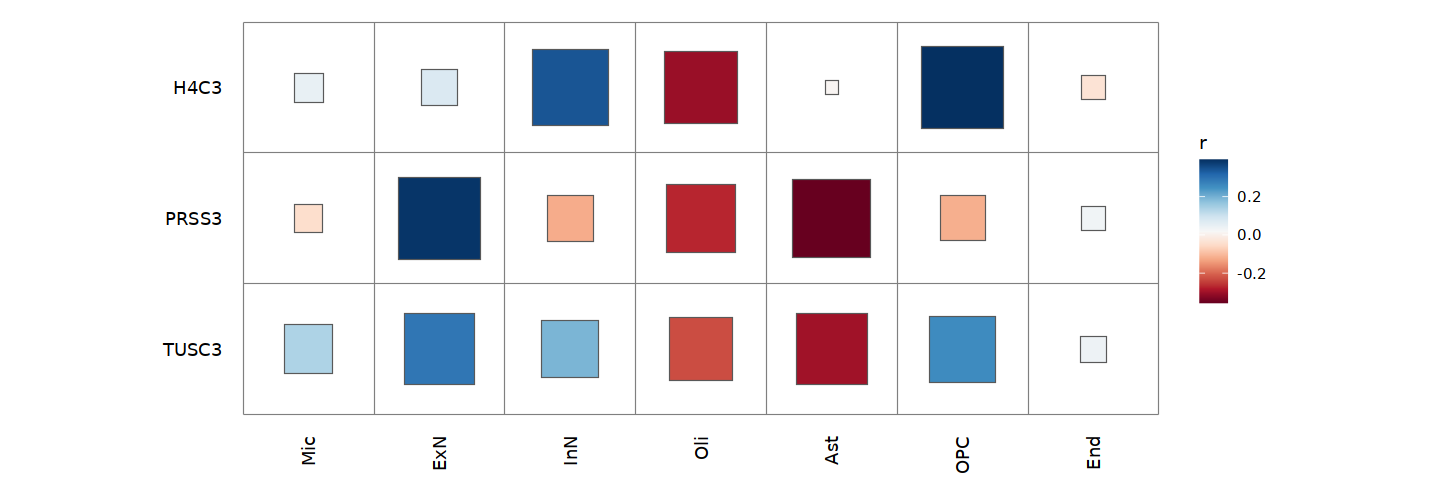

In [88]:
cor_res <- correlate(count, cells,method = "spearman")
  
qcorrplot(cor_res) +
  geom_square() +
  scale_fill_gradientn(colours = RColorBrewer::brewer.pal(11, "RdBu"))

In [89]:
options(repr.plot.width = 12,repr.plot.height = 4)

In [90]:
library(tidyr)

In [91]:
library(tibble)

In [92]:
# 先整理下数据
df_r <- cor_res$r %>% 
  as.data.frame() %>% 
  rownames_to_column(var = "gene") %>% 
  pivot_longer(-1,names_to = "cell_type",values_to = "correlation")

df_p <- cor_res$p %>% 
  as.data.frame() %>% 
  rownames_to_column(var = "gene") %>% 
  pivot_longer(-1,names_to = "cell_type",values_to = "pvalue")

df_cor <- df_r %>% 
  left_join(df_p) %>% 
  mutate(stars = cut(pvalue,breaks = c(-Inf,0.05,0.01,0.001,Inf),right = F,labels = c("***","**","*"," ")))
## Joining with `by = join_by(gene, cell_type)`

head(df_cor)

Joining with `by = join_by(gene, cell_type)`


gene,cell_type,correlation,pvalue,stars
<chr>,<chr>,<dbl>,<dbl>,<fct>
H4C3,Mic,0.04881519,0.77102194,
H4C3,ExN,0.07508346,0.65414059,
H4C3,InN,0.34181581,0.03569038,*
H4C3,Oli,-0.30558749,0.06207637,
H4C3,Ast,0.01083566,0.94851956,
H4C3,OPC,0.39413344,0.01434665,*


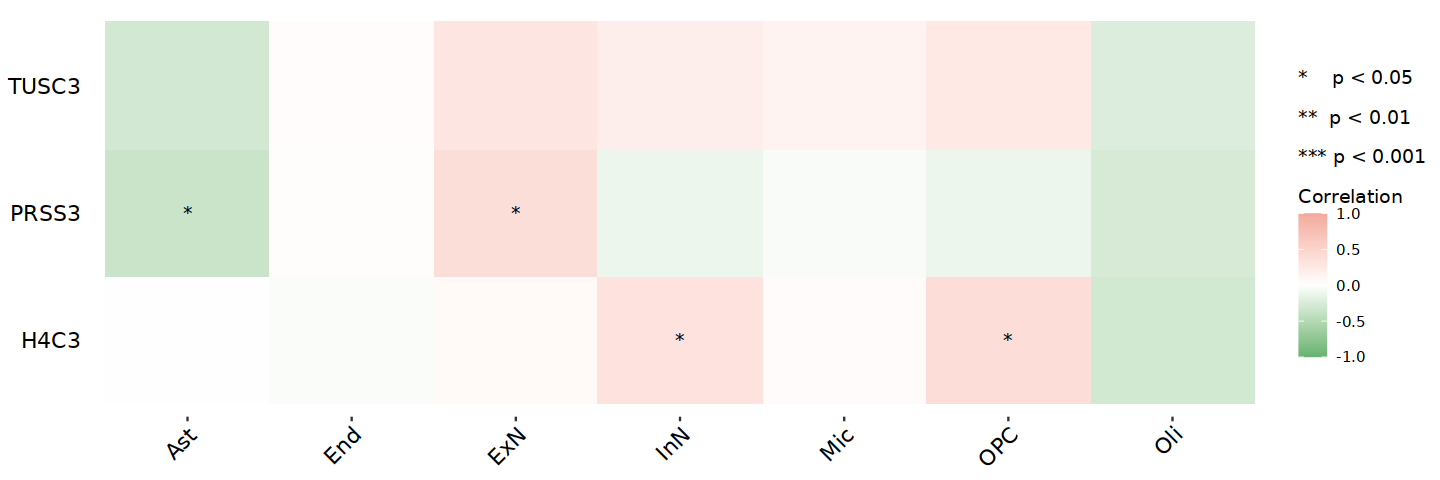

In [93]:
library(ggplot2)

ggplot(df_cor, aes(cell_type,gene))+
  geom_tile(aes(fill=correlation))+
  geom_text(aes(label=stars), color="black", size=4)+
  scale_fill_gradient2(low='#67B26F', high='#F2AA9D',mid = 'white',
                      limit=c(-1,1),name=paste0("*    p < 0.05","\n\n","**  p < 0.01","\n\n","*** p < 0.001","\n\n","Correlation"))+
  labs(x=NULL,y=NULL)+
  theme(axis.text.x = element_text(size=13,angle = 45,hjust = 1,color = "black"),
        axis.text.y = element_text(size=13,color = "black"),
        axis.ticks.y = element_blank(),
        panel.background=element_blank())

In [95]:
for (i in colnames(count)){

    # 以EGFR为例
df_egfr <- df_cor %>% 
  filter(gene==i) %>% dplyr::select(cell_type,correlation,pvalue)
colnames(df_egfr)[c(1,2)]= c('Cell','cor')
data = df_egfr
colnames(data)
p.col = c('gold','pink','orange','LimeGreen','darkgreen')
fcolor = function(x,p.col){
  color = ifelse(x>0.8,p.col[1],ifelse(x>0.6,p.col[2],ifelse(x>0.4,p.col[3],
                ifelse(x>0.2,p.col[4], p.col[5])
                )))
  return(color)
}

p.cex = seq(2.5, 5.5, length=5)
fcex = function(x){
  x=abs(x)
  cex = ifelse(x<0.1,p.cex[1],ifelse(x<0.2,p.cex[2],ifelse(x<0.3,p.cex[3],
              ifelse(x<0.4,p.cex[4],p.cex[5]))))
  return(cex)
}
points.color = fcolor(x=data$pvalue,p.col=p.col)
data$points.color = points.color
points.cex = fcex(x=data$cor)
data$points.cex = points.cex
data=data[order(data$cor),]

xlim = ceiling(max(abs(data$cor))*10)/10
pdf(file=paste0('./figure/',i,".pdf"), width=9, height=7)
layout(mat=matrix(c(1,1,1,1,1,0,2,0,3,0),nc=2),width=c(8,2.2),heights=c(1,2,1,2,1))
par(bg="white",las=1,mar=c(5,18,2,4),cex.axis=1.5,cex.lab=2)
plot(1,type="n",xlim=c(-xlim,xlim),ylim=c(0.5,nrow(data)+0.5),xlab="Correlation Coefficient",ylab="",yaxt="n",yaxs="i",axes=F)
rect(par('usr')[1],par('usr')[3],par('usr')[2],par('usr')[4],col="#F5F5F5",border="#F5F5F5")
grid(ny=nrow(data),col="white",lty=1,lwd=2)
#绘制图形的线段
segments(x0=data$cor,y0=1:nrow(data),x1=0,y1=1:nrow(data),lwd=4)
#绘制图形的圆圈
points(x=data$cor,y = 1:nrow(data),col = data$points.color,pch=16,cex=data$points.cex)
#展示免疫细胞的名称
text(par('usr')[1],1:nrow(data),data$Cell,adj=1,xpd=T,cex=1.5)

pvalue.text=ifelse(data$pvalue<0.001,'<0.001',sprintf("%.03f",data$pvalue))
redcutoff_cor=0
redcutoff_pvalue=0.05
text(par('usr')[2],1:nrow(data),pvalue.text,adj=0,xpd=T,col=ifelse(abs(data$cor)>redcutoff_cor & data$pvalue<redcutoff_pvalue,"red","black"),cex=1.5)
axis(1,tick=F)
par(mar=c(0,4,3,4))
plot(1,type="n",axes=F,xlab="",ylab="")
legend("left",legend=c(0.1,0.2,0.3,0.4,0.5),col="black",pt.cex=p.cex,pch=16,bty="n",cex=2,title="abs(cor)")

#绘制圆圈颜色的图例
par(mar=c(0,6,4,6),cex.axis=1.5,cex.main=2)
barplot(rep(1,5),horiz=T,space=0,border=NA,col=p.col,xaxt="n",yaxt="n",xlab="",ylab="",main="pvalue")
axis(4,at=0:5,c(1,0.8,0.6,0.4,0.2,0),tick=F)
dev.off()
    
}

### 相关性分析热图

In [704]:
head(im_ssgsea3,2)

,B_cells_naive,B_cells_memory,Plasma_cells,T_cells_CD8,T_cells_CD4_naive,T_cells_CD4_memory_resting,T_cells_CD4_memory_activated,T_cells_regulatory_(Tregs),T_cells_gamma_delta,NK_cells_resting,Monocytes,Macrophages_M0,Macrophages_M1,Macrophages_M2,Dendritic_cells_activated,Mast_cells_resting,Eosinophils,Neutrophils
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C10,0.0184552748,0,0.000000000,0.1555477,0.1075937,0.07354913,0.02066837,0.01598648,0,0.1247511,0.13777233,0,0,0,0.006854585,0.003319929,0,0.3355013
C11,0.0002202792,0,0.003778107,0.1195569,0.0575484,0.01656198,0.04863193,0.00353335,0,0.1968771,0.08732389,0,0,0,0.000000000,0.001022185,0,0.4649459


In [705]:
cor<- cor(im_ssgsea3)

In [707]:
library(corrplot)

Warning message:
"package 'corrplot' was built under R version 4.2.3"
corrplot 0.92 loaded



In [727]:
col2 <- colorRampPalette(c("#233151","white" ,"#F12F07"),alpha = TRUE)

In [728]:
# corrplot(cor, order = "hclust", addgrid.col = "grey70",type = "upper",
# outline = "orange",col = col2(100),method = "square",diag = F)

In [729]:
res1 <- cor.mtest(im_ssgsea3, conf.level = .95)
res2 <- cor.mtest(im_ssgsea3, conf.level = .99)
p.mat = res1$p
p.mat[1:5,1:5]

,B_cells_naive,B_cells_memory,Plasma_cells,T_cells_CD8,T_cells_CD4_naive
B_cells_naive,0.0000000,0.3719584,0.4340397,0.3048935,0.3729857
B_cells_memory,0.3719584,0.0000000,0.3957350,0.6447815,0.1971029
Plasma_cells,0.4340397,0.3957350,0.0000000,0.4598475,0.2960889
T_cells_CD8,0.3048935,0.6447815,0.4598475,0.0000000,0.4803271
T_cells_CD4_naive,0.3729857,0.1971029,0.2960889,0.4803271,0.0000000


In [733]:
options(repr.plot.width = 12,repr.plot.height = 12)

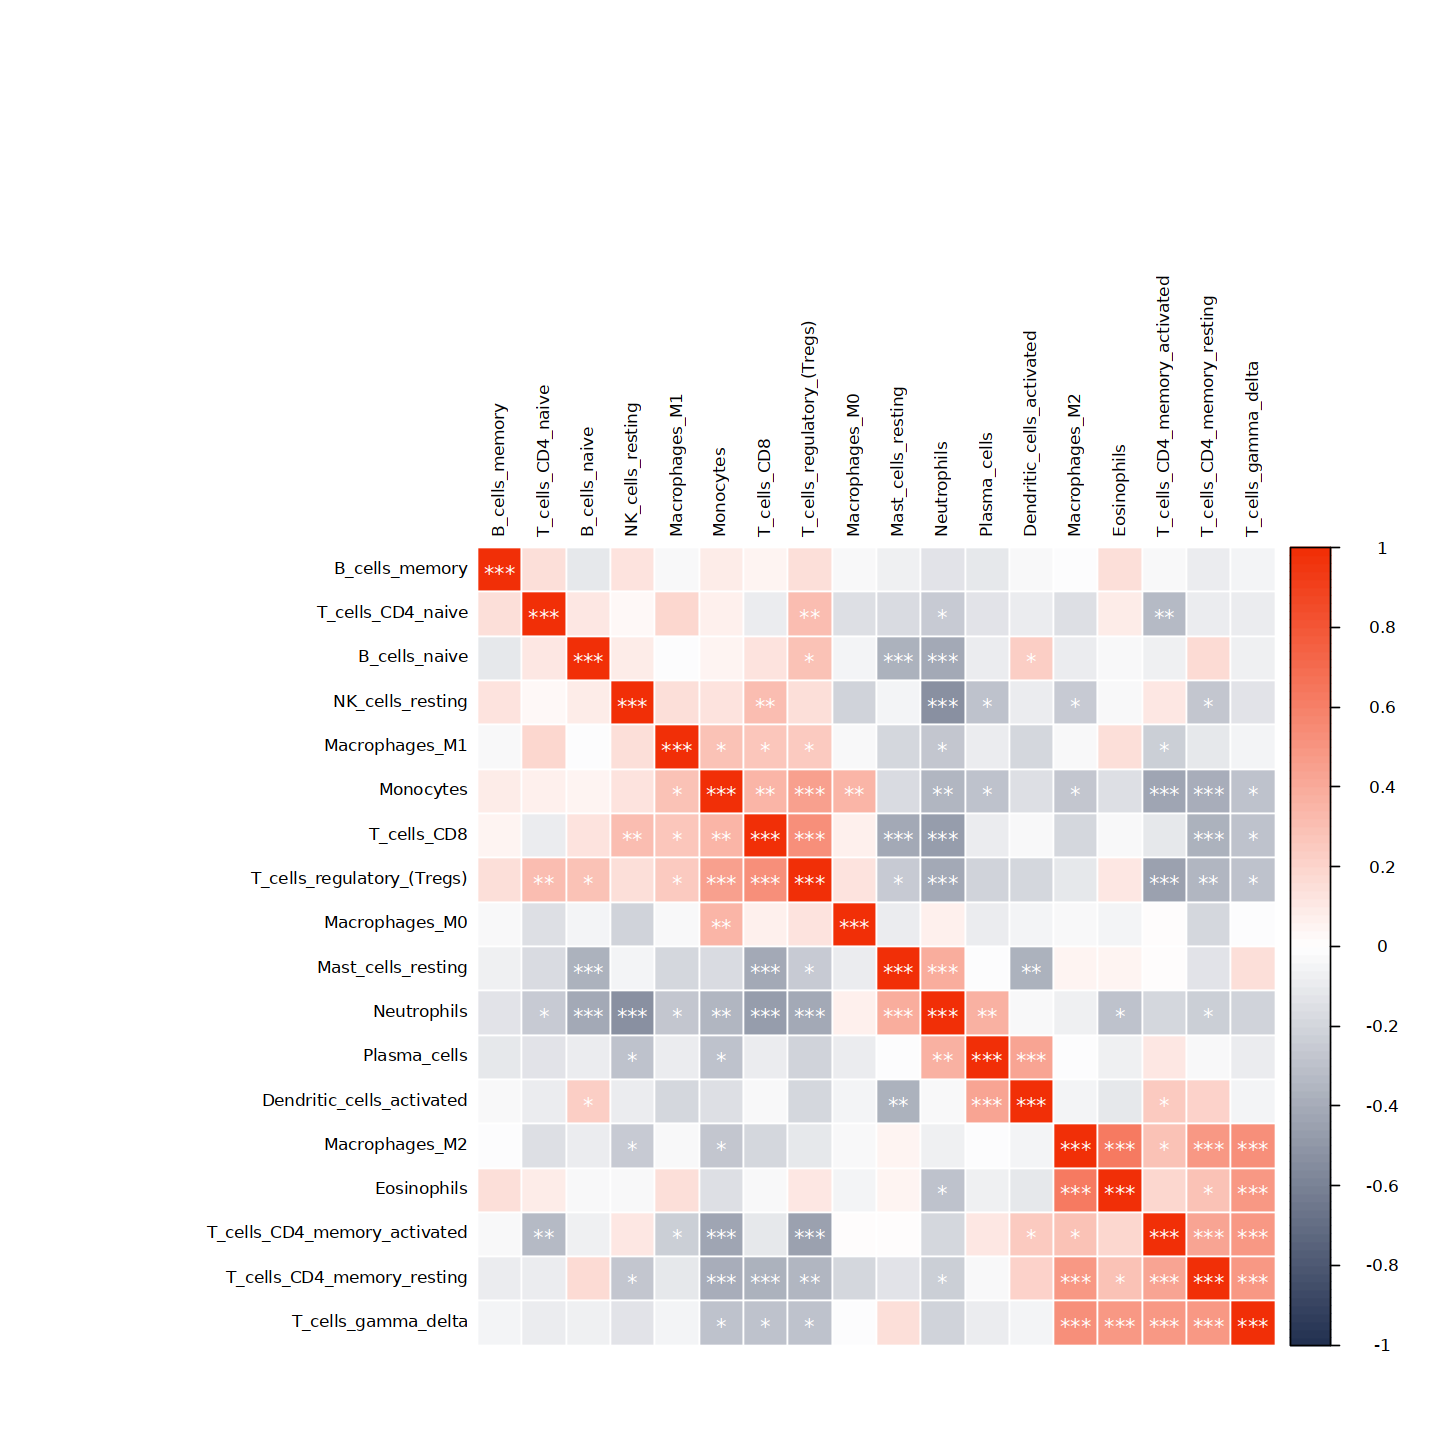

In [735]:
corrplot(cor, order = "hclust",col = col2(100),method = "color",
tl.col="black",tl.cex = 0.8,cl.pos = "r",cl.ratio = 0.2,
p.mat = res1$p, sig.level = c(.001, .01, .05),outline="white",
insig = "label_sig",pch.cex = 1, pch.col = "white")